\begin{equation}
\left\{\begin{array}{ll}
 u_t - u_{xx} = 0, \hskip 3mm (x,t)\in (-1,1) \times (0,1), \\[10pt]
 u(-1,t) = 0 = u(1,t), \hskip 20mm t\in  (0,1), \\[10pt]
 u(x,0) = \frac{4}{π}\cos(\frac{πx}{2}), \hskip 7mm   x\in (-1,1) ,\\[10pt]
 \end{array} \right.
\end{equation}



Solución exacta:
\begin{equation}
u(x,t) = \frac{4}{π}\exp{(\frac{π^2t}{4})}\cos(\frac{πx}{2}), (x,t) \in (-1,1) \times (0,1)
\end{equation}

# 1. Librerias

In [ ]:
! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=ec7fb70823a8ed767da21d0c4e275fd70c5b9394776e3938b3fb0a783d374883
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
# Importar librerias
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.autograd as grad
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
import math
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
import scipy.io

In [ ]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

In [ ]:
from re import T
#N=3000
Nf = 1000 # puntos para evaluar el residuo
print_freq = 2000 # imprimir cada epoca
steps =20000
t0 = 0.
tf = 1.
x0 = -1.
xf = 1.
#tf = 2
Nx = 200 # puntos totales para la x
Nt = 100 # puntos totales para la t

Nu = 100 #puntos de colocacion
Nf = 10000


# 2. Funciones auxiliares

In [ ]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1)
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def u_real(x,t):
  return (4/(np.pi))*torch.exp(-0.25*(np.pi**2)*t)*(torch.cos(0.5*np.pi*x))

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


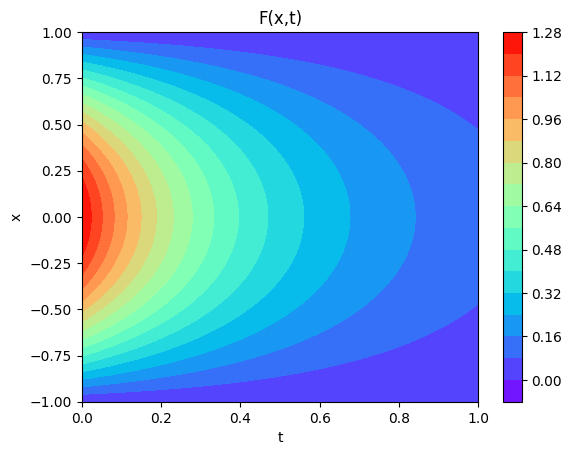

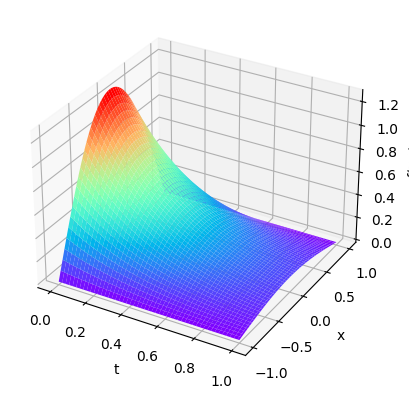

In [ ]:
x=torch.linspace(x0,xf,Nx).view(-1,1)
t=torch.linspace(t0,tf,Nt).view(-1,1)
# Create the mesh
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
u_real=u_real(X,T)
plot3D(x,t,u_real) #f_real was defined previously(function)

# 3. Red Neuronal

In [ ]:
# Fijamos la semilla
torch.manual_seed(1234)
np.random.seed(1234)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


In [ ]:
class PINN(nn.Module):     # definir la clase (al heredar de nn.Module clase PINN
                           # tiene acceso a muchas utilidades y métodos proporcionados por PyTorch
                           # para el entrenamiento y la evaluación de modelos

    def __init__(self, input_size, hidden_size, output_size):    # Inicializador
                           # llamamos al inicializador de la clase base nn.Module mediante super()
                           # Esto asegura que todas las funcionalidades de nn.Module se inicialicen correctamente
        super(PINN, self).__init__()

        # Definir las capas de la red neuronal (aqui 3 capas lineales: nn.Linear)
        # Estas capas representan las conexiones ponderadas entre las neuronas de capas consecutivas.
        #  nn.Linear(input_size, hidden_size)
        #  input_size : es la cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: la cantidad de salidas (neuronas en la capa actual)
        # Una capa lineal significa que salida = Entradas×Pesos + Sesgo

        # Capa 1: Entrada con input_size características, salida con hidden_size características
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        #self.fc4 = nn.Linear(hidden_size, hidden_size)
        # Capa 3: Entrada con hidden_size características, salida con 1 característica
        self.fc5 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos (I): Random Initialization
        # Inicializar los pesos de las capas con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # o
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # Inicialización de pesos (II): Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica o la función logística (sigmoid).
        # Ayuda a mantener una varianza constante a través de las capas
        ## Sale mejor en este ejemplo que sin dicha inicializacion
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        #nn.init.xavier_normal_(self.fc4.weight)
        nn.init.xavier_normal_(self.fc5.weight)
        # Inicialización de pesos (III): He Initialization: Similar a la inicialización de Xavier,
        # pero ajustada para su uso con funciones de activación ReLU (Rectified Linear Unit).
        #nn.init.kaiming_normal_(model.fc1.weight)
        #nn.init.kaiming_normal_(model.fc2.weight)
        #nn.init.kaiming_normal_(model.fc3.weight)

        # Inicialización de pesos (IV):  LeCun Initialization:
        # Inicialización propuesta por LeCun para funciones de activación como la tangente hiperbólica
        # nn.init.normal_(layer.weight, mean=0, std=np.sqrt(1 / layer.weight.shape[0]))
        # init.normal_(self.fc1.weight, mean=0, std=np.sqrt(1 / self.fc1.weight.shape[0]))
        # init.normal_(self.fc2.weight, mean=0, std=np.sqrt(1 / self.fc2.weight.shape[0]))
        # init.normal_(self.fc3.weight, mean=0, std=np.sqrt(1 / self.fc3.weight.shape[0]))

        # Inicializacion de las bias
        nn.init.zeros_(self.fc1.bias.data)
        nn.init.zeros_(self.fc2.bias.data)
        nn.init.zeros_(self.fc3.bias.data)
        #nn.init.zeros_(self.fc4.bias.data)
        nn.init.zeros_(self.fc5.bias.data)

    def forward(self, x):
       # Define la operación hacia adelante de la red neuronal, i.e cómo se realiza la operación hacia adelante en la red neuronal.
       # Se aplican funciones de activación tangente hiperbólica (torch.tanh) después de cada capa lineal
       # En este caso, el método forward toma la entrada x y la pasa a través de las capas fc1, fc2 y fc3
       # utilizando la función de activación tangente hiperbólica (torch.tanh) después de las dos primeras capas.
       # La última capa (fc3) no tiene una función de activación
       if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
       x = x.float()
       #x = torch.tanh(self.fc1(x))
       #x = torch.tanh(self.fc2(x))
       #x = torch.tanh(self.fc3(x))
       #x = torch.tanh(self.fc4(x))
       #x = self.fc5(x)             # No aplicamos función de activación en la última capa fc3

       x = torch.sigmoid(self.fc1(x))
       x = torch.sigmoid(self.fc2(x))
       x = torch.sigmoid(self.fc3(x))
       #x = torch.sigmoid(self.fc4(x))
       x = self.fc5(x)

       # Aplicacion a la sigmoide
       #x = torch.sigmoid(self.fc1(x))
       #x = torch.sigmoid(self.fc2(x))
       #x = self.fc3(x)

       return x

## Funciones de perdida

In [ ]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self,model,x_BC,u_BC,f_t,f_xx,g):
        f = f_t-f_xx;
        # g =[x,t]
        #h = torch.exp(-g[:,1])*(torch.sin(np.pi*g[:,0])-np.pi**2*torch.sin(np.pi*g[:,0]))
        #fh =f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
        fh =f_t-f_xx
        loss_pde = self.mse_loss(fh, f_hat)
        u_BN = initial_condition(model, x_BC)
        loss_condition = self.mse_loss(u_BN, u_BC) #condiciones de contorno e iniciales
        #total_loss = loss_pde + loss_condition
        total_loss = loss_pde + 10*loss_condition
        return total_loss

In [ ]:
# Función para calcular la derivada
def compute_derivative(model, x):
    g = x.clone()
    g.requires_grad_(True)
    f = model(g)
    f_x_t = torch.autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device), retain_graph=True, create_graph=True)[0] #primera derivada
    f_xx_tt = torch.autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), retain_graph=True, create_graph=True)[0] #segunda derivada
    f_t = f_x_t[:,[1]]
    f_xx = f_xx_tt[:,[0]]
    return f_t, f_xx, g

# Función para calcular las condiciones iniciales y de contorno
def initial_condition(model, x_BC):
    return model(x_BC)

In [ ]:
# Función de entrenamiento
def train(model, optimizer,loss_fn, x_BC, u_BC, X_train, num_epochs,scheduler):
  """
  X_BC = (x,t) donde estan las condciones de contorno e iniciales
  U_BC = valores reales de ellas
  X_train = datos de entrenamiento
  """

  loss_history = []    # Lista para almacenar la pérdida en cada época
  learning_rates = []  # Lista para almacenar los learning rates en cada iteración/época

  for epoch in range(num_epochs):            # Bucle de entrenamiento
    # Calcular las predicciones de la red y las derivadas
    model.train()

    #h = model(t_data)

    f_t, f_xx, g = compute_derivative(model, X_train)

    # Calcular la pérdida
    #loss = loss_fn(yh, y_data)
    loss = loss_fn(model,x_BC,u_BC,f_t,f_xx,g)
    # Optimización
    optimizer.zero_grad()  # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()        # Se realiza la retropropagación backward
    optimizer.step()       # Se actualizan los parámetros del modelo mediante el optimizador (optimizer)
    scheduler.step()
    loss_history.append(loss.item())    # almacentar el error


    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)             # almacentar el learning rate
    # Imprimir el progreso
    if (epoch + 1) % print_freq == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {loss.item()}')

  return loss_history, learning_rates  # Devolver la lista de pérdida al final del entrenamiento y el lerning rate

Preparación de los datos

In [ ]:
#X,T malla
#u_real sol real
print(x.shape,t.shape,u_real.shape)
print(X.shape,T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


In [ ]:
X # por filas iguales
T # por columnas iguales

tensor([[0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        ...,
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000]])

In [ ]:
# Condiciones iniciales
# u(x,0) = 4/pi*cos(pi/2 * x)
# x -> primera columna del vector X(cojo todas)
# t=0 -> primera columna de
X_left = X[:,0]
print(X_left)
T_0 = T[:,0]
left_X=torch.hstack((X[:,0][:,None],T_0[:,None]))
left_U = (4/np.pi)*torch.cos(0.5*np.pi*left_X[:,0]).unsqueeze(1)


tensor([-1.0000, -0.9899, -0.9799, -0.9698, -0.9598, -0.9497, -0.9397, -0.9296,
        -0.9196, -0.9095, -0.8995, -0.8894, -0.8794, -0.8693, -0.8593, -0.8492,
        -0.8392, -0.8291, -0.8191, -0.8090, -0.7990, -0.7889, -0.7789, -0.7688,
        -0.7588, -0.7487, -0.7387, -0.7286, -0.7186, -0.7085, -0.6985, -0.6884,
        -0.6784, -0.6683, -0.6583, -0.6482, -0.6382, -0.6281, -0.6181, -0.6080,
        -0.5980, -0.5879, -0.5779, -0.5678, -0.5578, -0.5477, -0.5377, -0.5276,
        -0.5176, -0.5075, -0.4975, -0.4874, -0.4774, -0.4673, -0.4573, -0.4472,
        -0.4372, -0.4271, -0.4171, -0.4070, -0.3970, -0.3869, -0.3769, -0.3668,
        -0.3568, -0.3467, -0.3367, -0.3266, -0.3166, -0.3065, -0.2965, -0.2864,
        -0.2764, -0.2663, -0.2563, -0.2462, -0.2362, -0.2261, -0.2161, -0.2060,
        -0.1960, -0.1859, -0.1759, -0.1658, -0.1558, -0.1457, -0.1357, -0.1256,
        -0.1156, -0.1055, -0.0955, -0.0854, -0.0754, -0.0653, -0.0553, -0.0452,
        -0.0352, -0.0251, -0.0151, -0.00

In [ ]:
# Condiciones de contorno
# u(-1,t)=0=u(1,t)
# x=-1, primera fila, t(todas) primera fila
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None]))
bottom_U=torch.zeros(bottom_X.shape[0],1) # vector de ceros
# x=1, ultima fila
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # vector de ceros
top_U=torch.zeros(top_X.shape[0],1)

In [ ]:
# lo vamos a poner de forma conjuntoa
# [iniciales, contorno]

X_train=torch.vstack([left_X,bottom_X,top_X])
U_train=torch.vstack([left_U,bottom_U,top_U])

In [ ]:
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=u_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


In [ ]:
# Puntos de colocacion, lo hacemos mediante el hipercubo latino
#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
U_train_Nu=U_train[idx,:]
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points



In [ ]:
# Pasamos los datos al GPU
torch.manual_seed(1234)
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
U_train_Nu=U_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution


In [ ]:
print(X_train_Nf.shape, X_train_Nu.shape)

torch.Size([10100, 2]) torch.Size([100, 2])


In [ ]:
# Crear una instancia del modelo y del optimizador
# model = PINN(input_size, hidden_size, output_size)
input_size = 2
#hidden_size = 5 , mejor
#hidden_size = 32
hidden_size = 10
output_size = 1
#learnig_rate = 0.001
#learning_rate = 0.02
learnig_rate = 0.15
model = PINN(input_size, hidden_size, output_size)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)
loss_fn = PINNLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.99)


# Registrar el tiempo de inicio
start_time = time.time()

#num_epoch = 12000
#num_epoch = 38000
#num_epoch = 30000
num_epoch = 20000
#num_epoch = 25000
#num_epoch = 48000
#num_epoch = 50000
#num_epoch = 60000
# Entrenar el modelo utilizando la función de entrenamiento
loss_history, learning_rates = train(model, optimizer,loss_fn, X_train_Nu, U_train_Nu, X_train_Nf, num_epoch,scheduler)

# Registrar el tiempo de finalización
end_time = time.time()

# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

PINN(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)
Epoch [2000/20000], Total Loss: 0.001367134158499539
Epoch [4000/20000], Total Loss: 0.0006629838608205318
Epoch [6000/20000], Total Loss: 0.00048608932411298156
Epoch [8000/20000], Total Loss: 0.0004027585091535002
Epoch [10000/20000], Total Loss: 0.0003653551684692502
Epoch [12000/20000], Total Loss: 0.00034268785384483635
Epoch [14000/20000], Total Loss: 0.00032645356259308755
Epoch [16000/20000], Total Loss: 0.0003141310880891979
Epoch [18000/20000], Total Loss: 0.0003058982838410884
Epoch [20000/20000], Total Loss: 0.0003015118127223104
 
Tiempo de ejecución: 330.25922560691833 segundos


In [ ]:
x1=X_test[:,0]
t1=X_test[:,1]

In [ ]:
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
X_test=x_test.float().to(device) # the input dataset (complete)

In [ ]:
X_test.shape

torch.Size([20000, 2])

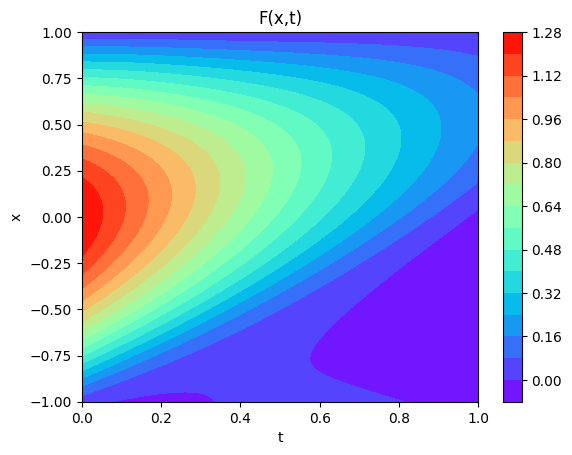

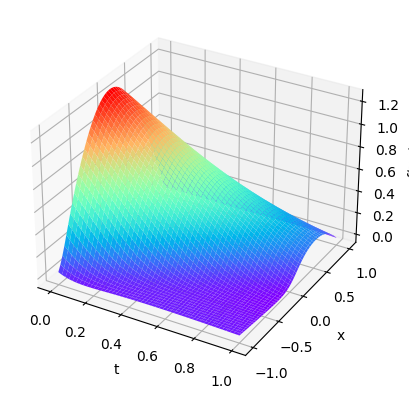

In [ ]:
u1=model(X_test)

arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=u1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

In [ ]:
arr_T1

tensor([[0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        ...,
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000]])

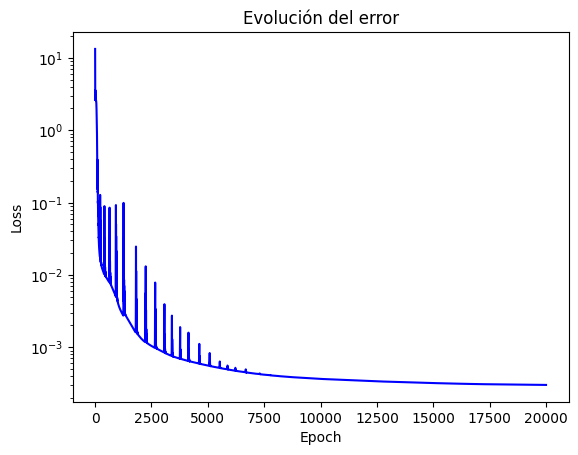

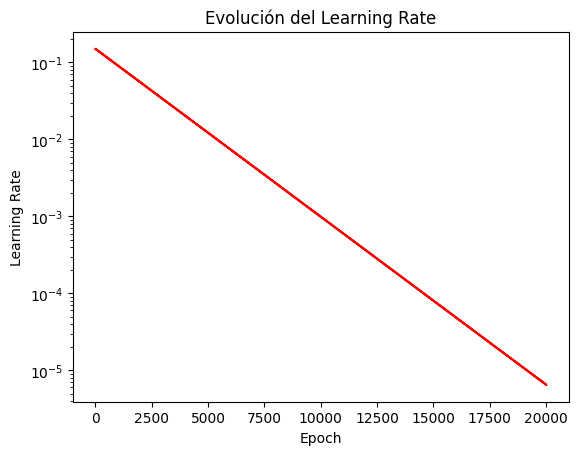

In [ ]:
plt.figure()
# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolución del error')
plt.yscale('log')
plt.show()

plt.figure()
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')
plt.yscale('log')


# Ajustar el diseño y mostrar la gráfica

plt.show()